In [120]:
!pip install scikit_posthocs

In [5]:
#Imports
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scikit_posthocs as sp
from scipy.stats import skew, chi2_contingency, spearmanr, mannwhitneyu, kruskal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [7]:
#V de Cramers
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

In [19]:
#Extrair dados do banco de dados
conn = sqlite3.connect('database/airline_satisfaction.db')

df = pd.read_sql_query("SELECT * FROM satisfacao_clientes", conn)

conn.close()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [23]:
#Visualização dos tipos das colunas
df.dtypes

Unnamed: 0                             int64
id                                     int64
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure 

In [25]:
#Verificar tamanho do dataset
df.size

649400

In [8]:
#Visualização das 5 primeiras linhas
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [9]:
#Deletar colunas irrelevantes e verificando exclusão
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [11]:
#Verificação de valores nulos
print('Nulos: ', df.isnull().sum())

#Verificação de duplicatas
print('Duplicatas :', df.duplicated().sum())

Nulos:  id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0
dtype: int64
Duplicatas : 0


In [12]:
#Cálculo de assimetria
print('Assimetria: ', df['Arrival Delay in Minutes'].skew())

Assimetria:  6.984497404158308


In [13]:
#Regra de Doane
g1 = skew(df['Arrival Delay in Minutes'].dropna())

n = len(df['Arrival Delay in Minutes'].dropna())
sigma_g1 = np.sqrt((6 * (n - 2)) / ((n + 1) * (n * 3)))

k = int(1 + np.log2(n) + np.log2(1 + abs(g1) / sigma_g1))

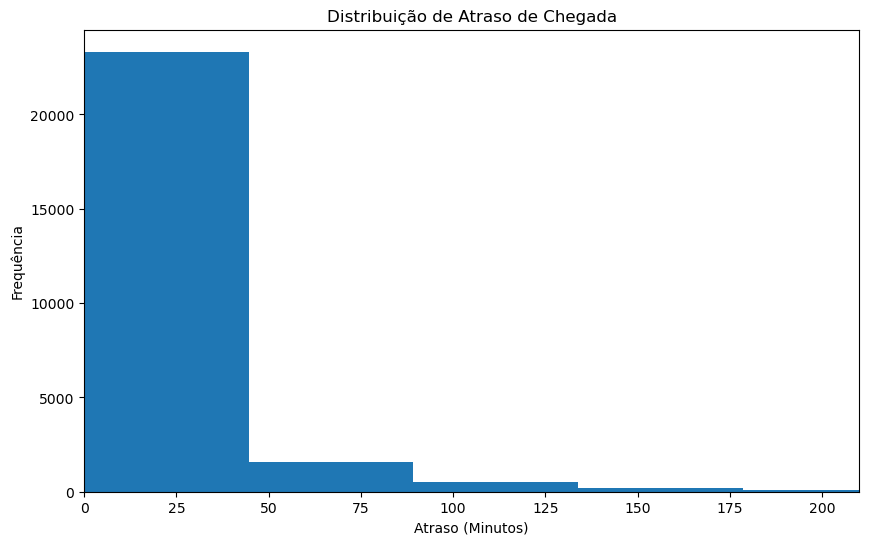

In [14]:
#Histograma
plt.figure(figsize=(10,6))
plt.hist(df['Arrival Delay in Minutes'], bins=k)
plt.title('Distribuição de Atraso de Chegada')
plt.xlabel('Atraso (Minutos)')
plt.ylabel('Frequência')
plt.xlim(0, 210)
plt.show()

In [22]:
#Verificação da moda, média e mediana
moda = df['Arrival Delay in Minutes'].dropna().mode()[0]
print('Moda: ', moda)
mediana = df['Arrival Delay in Minutes'].dropna().median()
print('Mediana :', mediana)
media = df['Arrival Delay in Minutes'].dropna().mean()
print('Média: ', media)

Moda:  0.0
Mediana : 0.0
Média:  14.74085660217047


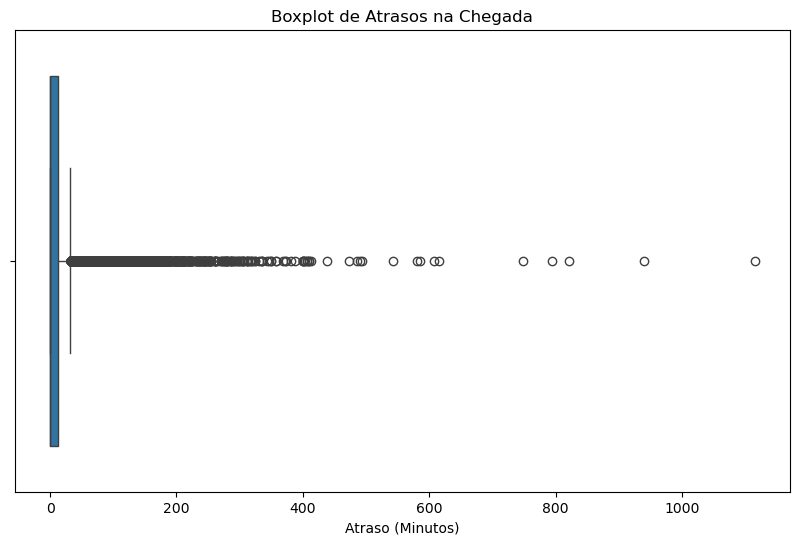

In [27]:
#Verificação de outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Arrival Delay in Minutes'].dropna())
plt.title('Boxplot de Atrasos na Chegada')
plt.xlabel('Atraso (Minutos)')
plt.show()

In [29]:
#Preenchimento de valores nulos com 0
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(0)

In [32]:
#Nova verificação de valores nulos
print('Nulos: ', df.isnull().sum())

Nulos:  id                                   0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64


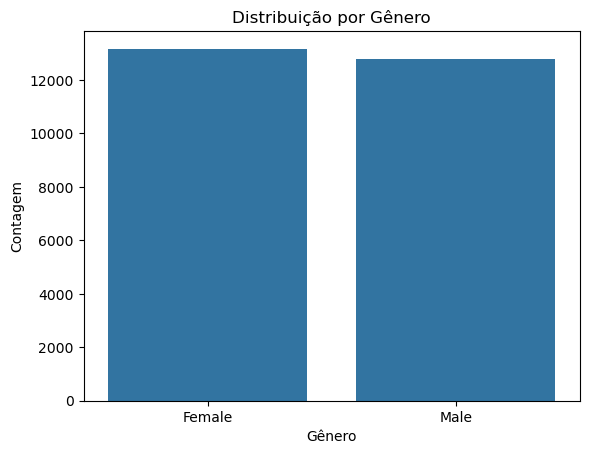

In [34]:
#Contagem por gênero
sns.countplot(x='Gender', data=df)
plt.title('Distribuição por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Contagem')
plt.show()

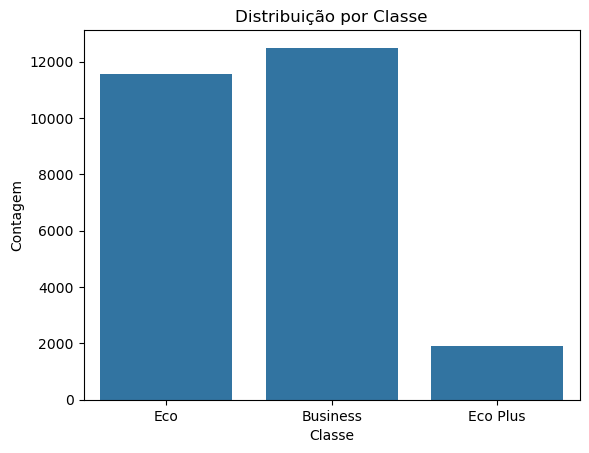

In [36]:
#Contagem por classe
sns.countplot(x='Class', data=df)
plt.title('Distribuição por Classe')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.show()

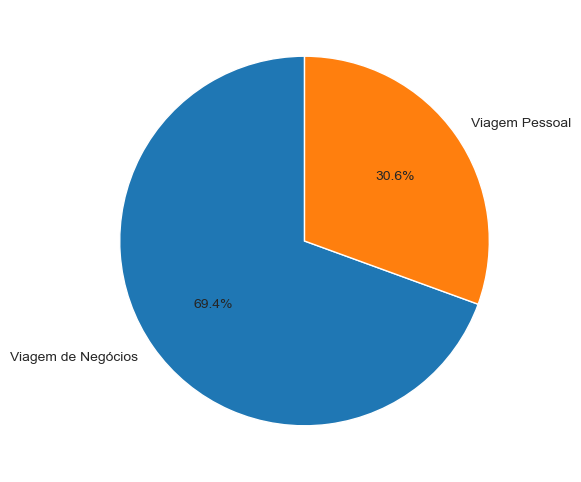

In [38]:
#Proporção por tipo de viagem
travel_counts = df['Type of Travel'].value_counts()

sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.pie(travel_counts, labels=['Viagem de Negócios', 'Viagem Pessoal'], autopct='%1.1f%%', startangle=90)
plt.show()

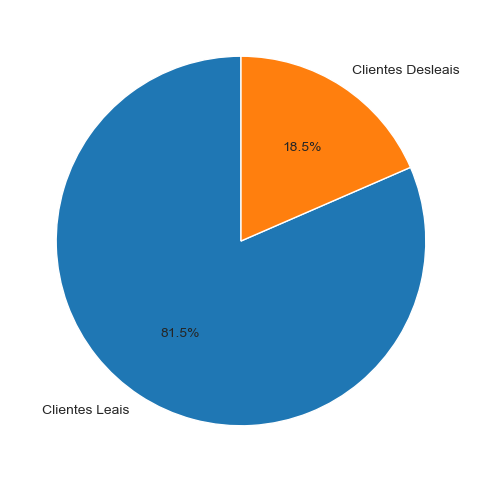

In [40]:
#Proporção de tipo de clientes
costumer_type = df['Customer Type'].value_counts()

sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.pie(costumer_type, labels=['Clientes Leais', 'Clientes Desleais'], autopct='%1.1f%%', startangle=90)
plt.show()

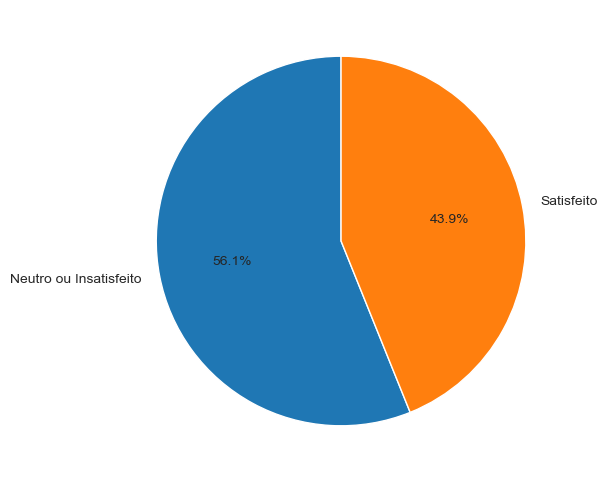

In [42]:
#Proporção de clientes por satisfação
satisfaction = df['satisfaction'].value_counts()

sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.pie(satisfaction, labels=['Neutro ou Insatisfeito', 'Satisfeito'], autopct='%1.1f%%', startangle=90)
plt.show()

In [44]:
#Criação de faixas etárias
bins = [0, 18, 25, 40, 60, 100]
labels = ['<18', '18-25', '26-40', '41-60', '60+']
df['Age Range'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

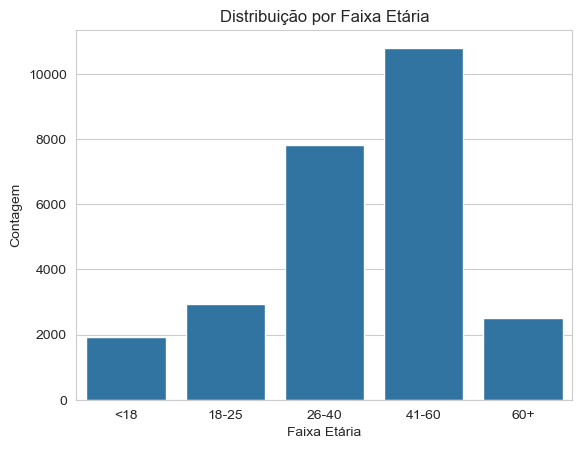

In [46]:
#Contagem por faixa etária
sns.countplot(x='Age Range', data=df)
plt.title('Distribuição por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Contagem')
plt.show()

In [48]:
#Categorização de satisfação
df['satisfaction'] = df['satisfaction'].map({
    'satisfied':1,
    'neutral or dissatisfied':0
})

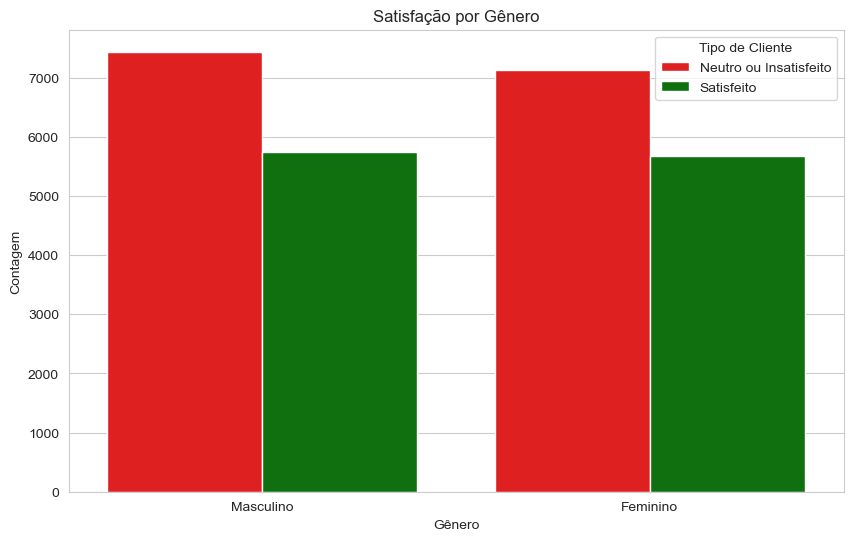

In [50]:
# Satisfação por gênero
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Gender', hue='satisfaction', data=df, palette={0: 'red', 1: 'green'})
plt.title('Satisfação por Gênero')

plt.xlabel('Gênero')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Masculino', 'Feminino'])

plt.ylabel('Contagem')

plt.legend(title='Tipo de Cliente', labels=['Neutro ou Insatisfeito', 'Satisfeito'])

plt.show()

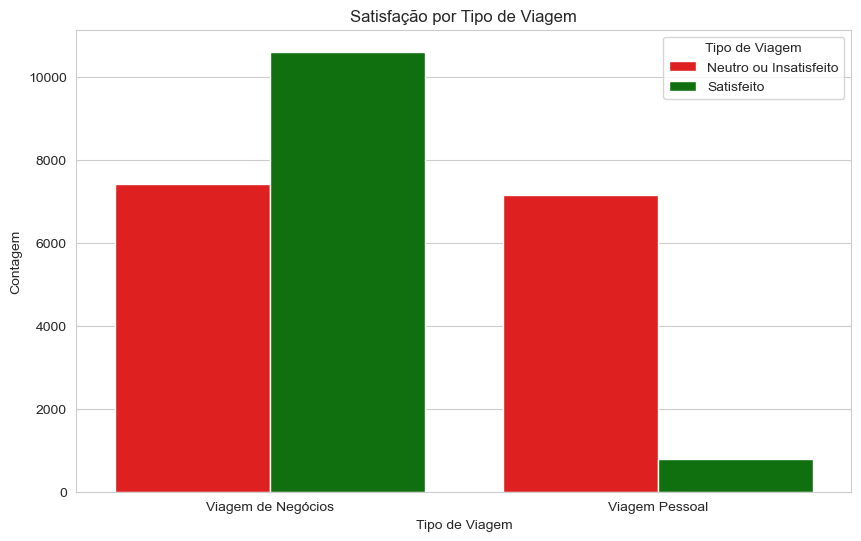

In [52]:
#Satisfação por tipo de viagem
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Type of Travel', hue='satisfaction', data=df, palette={0: 'red', 1: 'green'})
plt.title('Satisfação por Tipo de Viagem')

plt.xlabel('Tipo de Viagem')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Viagem de Negócios', 'Viagem Pessoal'])

plt.ylabel('Contagem')

plt.legend(title='Tipo de Viagem', labels=['Neutro ou Insatisfeito', 'Satisfeito'])
plt.show()

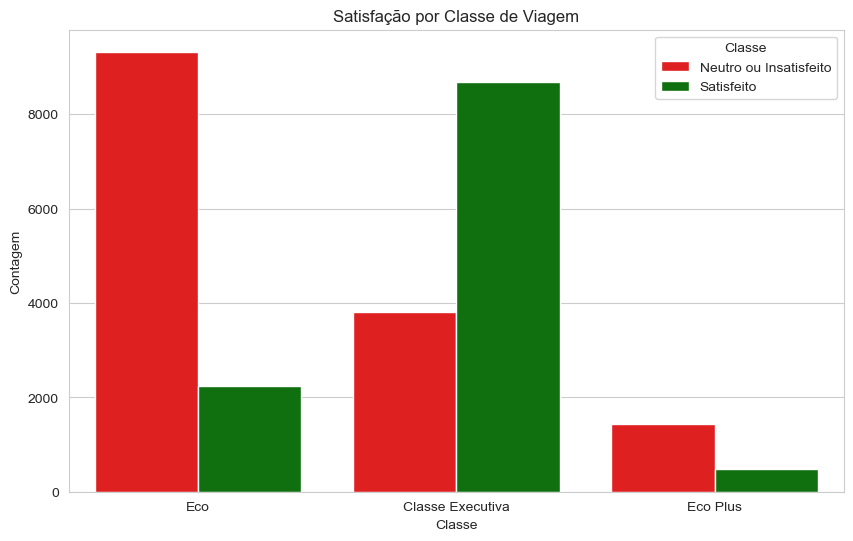

In [54]:
#Satisfação por classe
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Class', hue='satisfaction', data=df, palette={0: 'red', 1: 'green'})
plt.title('Satisfação por Classe de Viagem')

plt.xlabel('Classe')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Eco', 'Classe Executiva', 'Eco Plus'])

plt.ylabel('Contagem')

plt.legend(title='Classe', labels=['Neutro ou Insatisfeito', 'Satisfeito'])
plt.show()

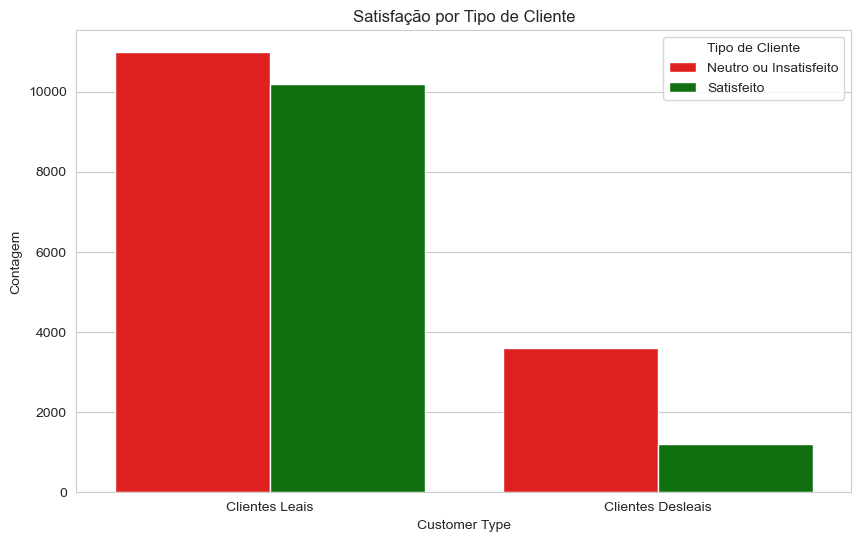

In [56]:
#Satisfação por tipo de cliente
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Customer Type', hue='satisfaction', data=df, palette={0: 'red', 1: 'green'})
plt.title('Satisfação por Tipo de Cliente')

plt.xlabel('Customer Type')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Clientes Leais', 'Clientes Desleais'])

plt.ylabel('Contagem')

plt.legend(title='Tipo de Cliente', labels=['Neutro ou Insatisfeito', 'Satisfeito'])
plt.show()

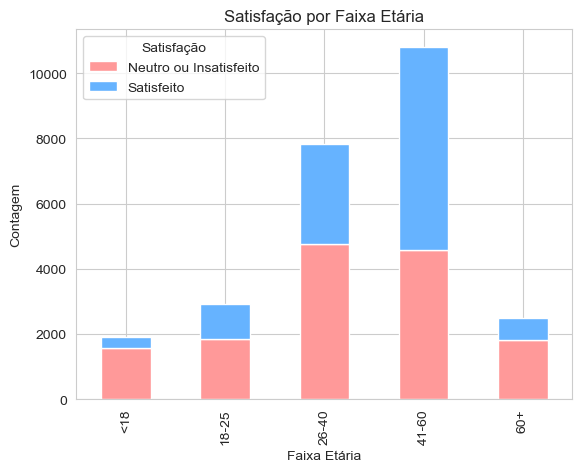

In [58]:
#Satisfação por faixa etária
age_range = df.groupby(['Age Range', 'satisfaction'], observed=True).size().unstack()
age_range.plot(kind='bar', stacked=True, color=['#ff9999', '#66b3ff'])
plt.title('Satisfação por Faixa Etária')

plt.xlabel('Faixa Etária')
plt.ylabel('Contagem')
plt.legend(title='Satisfação', labels=['Neutro ou Insatisfeito', 'Satisfeito'])
plt.show()

In [60]:
#Criação de categorias de atraso
bins = [-1, 0, 15, 60, float('inf')]
labels = ['No Delay', 'Short Delay', 'Moderate Delay', 'Long Delay']

df['Departure Delay Category'] = pd.cut(df['Departure Delay in Minutes'], bins=bins, labels=labels)
df['Arrival Delay Category'] = pd.cut(df['Arrival Delay in Minutes'], bins=bins, labels=labels)

In [90]:
#Separação de categorias para inferência categórica
categorical_tests = ['Gender', 'Customer Type', 'Type of Travel', 'Age Range', 'Class', 'Departure Delay Category',
                    'Arrival Delay Category']

#Separação de categorias para inferência ordinal
ordinal_tests = ['Seat comfort', 'Cleanliness', 'On-board service', 'Inflight service', 'Inflight entertainment', 'Inflight wifi service', 
             'Online boarding', 'Ease of Online booking', 'Departure/Arrival time convenient', 'Flight Distance']

In [92]:
#Testes qui quadrado para verificar impacto entre classes e satisfação 
for category in categorical_tests:
    contingency_table = pd.crosstab(df[category], df['satisfaction'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    print(f"Qui-Quadrado para {category} vs. Satisfação: p-valor = {p_value:.4f}")

Qui-Quadrado para Gender vs. Satisfação: p-valor = 0.2421
Qui-Quadrado para Customer Type vs. Satisfação: p-valor = 0.0000
Qui-Quadrado para Type of Travel vs. Satisfação: p-valor = 0.0000
Qui-Quadrado para Age Range vs. Satisfação: p-valor = 0.0000
Qui-Quadrado para Class vs. Satisfação: p-valor = 0.0000
Qui-Quadrado para Departure Delay Category vs. Satisfação: p-valor = 0.0000
Qui-Quadrado para Arrival Delay Category vs. Satisfação: p-valor = 0.0000


In [94]:
#Uso do V de Cramer para investigar impacto entre categorias e a satisfação
for category in categorical_tests:
    contingency_table = pd.crosstab(df[category], df['satisfaction'])
    v_cramer = cramers_v(contingency_table)
    print(f"V de Cramer para {category} vs. Satisfação: {v_cramer:.4f}")

V de Cramer para Gender vs. Satisfação: 0.0073
V de Cramer para Customer Type vs. Satisfação: 0.1795
V de Cramer para Type of Travel vs. Satisfação: 0.4532
V de Cramer para Age Range vs. Satisfação: 0.2610
V de Cramer para Class vs. Satisfação: 0.4977
V de Cramer para Departure Delay Category vs. Satisfação: 0.0745
V de Cramer para Arrival Delay Category vs. Satisfação: 0.0963


In [96]:
#Mann-Whitney U para dados checar se há uma grande diferença na média entre variáveis ordinais e os grupos "satisfeito" e "insatisfeito"
for var in ordinal_tests:
    satisfied = df[df['satisfaction'] == 1][var]
    dissatisfied = df[df['satisfaction'] == 0][var]
    u_stat, p_value = mannwhitneyu(satisfied, dissatisfied, alternative='two-sided')
    print(f'Teste de Mann-Whitney U para {var} vs. Satisfação: p-valor = {p_value:.4f}')
    print(f'Média de {var} (Satisfeitos): {satisfied.mean():.2f}')
    print(f'Média de {var} (Insatisfeitos): {dissatisfied.mean():.2f}\n')

Teste de Mann-Whitney U para Seat comfort vs. Satisfação: p-valor = 0.0000
Média de Seat comfort (Satisfeitos): 3.97
Média de Seat comfort (Insatisfeitos): 3.04

Teste de Mann-Whitney U para Cleanliness vs. Satisfação: p-valor = 0.0000
Média de Cleanliness (Satisfeitos): 3.76
Média de Cleanliness (Insatisfeitos): 2.92

Teste de Mann-Whitney U para On-board service vs. Satisfação: p-valor = 0.0000
Média de On-board service (Satisfeitos): 3.85
Média de On-board service (Insatisfeitos): 3.02

Teste de Mann-Whitney U para Inflight service vs. Satisfação: p-valor = 0.0000
Média de Inflight service (Satisfeitos): 3.98
Média de Inflight service (Insatisfeitos): 3.39

Teste de Mann-Whitney U para Inflight entertainment vs. Satisfação: p-valor = 0.0000
Média de Inflight entertainment (Satisfeitos): 3.96
Média de Inflight entertainment (Insatisfeitos): 2.89

Teste de Mann-Whitney U para Inflight wifi service vs. Satisfação: p-valor = 0.0000
Média de Inflight wifi service (Satisfeitos): 3.15
Médi

In [98]:
#Uso da correlação de Spearman para investigar impacto entre as variáveis intervalares e a satisfação
for category in ordinal_tests:
    corr, p_value = spearmanr(df[category], df['satisfaction'])
    print(f"Correlação de Spearman para {category} vs. Satisfação: {corr:.4f}\n p-valor: {p_value:.4f}")

Correlação de Spearman para Seat comfort vs. Satisfação: 0.3588
 p-valor: 0.0000
Correlação de Spearman para Cleanliness vs. Satisfação: 0.3129
 p-valor: 0.0000
Correlação de Spearman para On-board service vs. Satisfação: 0.3288
 p-valor: 0.0000
Correlação de Spearman para Inflight service vs. Satisfação: 0.2665
 p-valor: 0.0000
Correlação de Spearman para Inflight entertainment vs. Satisfação: 0.4007
 p-valor: 0.0000
Correlação de Spearman para Inflight wifi service vs. Satisfação: 0.2843
 p-valor: 0.0000
Correlação de Spearman para Online boarding vs. Satisfação: 0.5436
 p-valor: 0.0000
Correlação de Spearman para Ease of Online booking vs. Satisfação: 0.1638
 p-valor: 0.0000
Correlação de Spearman para Departure/Arrival time convenient vs. Satisfação: -0.0623
 p-valor: 0.0000
Correlação de Spearman para Flight Distance vs. Satisfação: 0.2535
 p-valor: 0.0000


In [100]:
#Kruskal-Wallis para verificar se há uma diferença no impacto da satisfação por classe 
groups = [df[df['Class'] == cat]['satisfaction'] for cat in df['Class'].unique()]

stat, p_value = kruskal(*groups)
print(f"Kruskal-Wallis para Class vs. Satisfação: estatística={stat:.4f}, p-valor={p_value:.4f}")

Kruskal-Wallis para Class vs. Satisfação: estatística=6434.7875, p-valor=0.0000


In [102]:
#Identificar quais grupos são os mais discrepantes entre as classes
dunn = sp.posthoc_dunn(df, val_col='satisfaction', group_col='Class', p_adjust='bonferroni')

print(dunn)

               Business       Eco       Eco Plus
Business   1.000000e+00  0.000000  3.366665e-295
Eco        0.000000e+00  1.000000   3.177881e-05
Eco Plus  3.366665e-295  0.000032   1.000000e+00


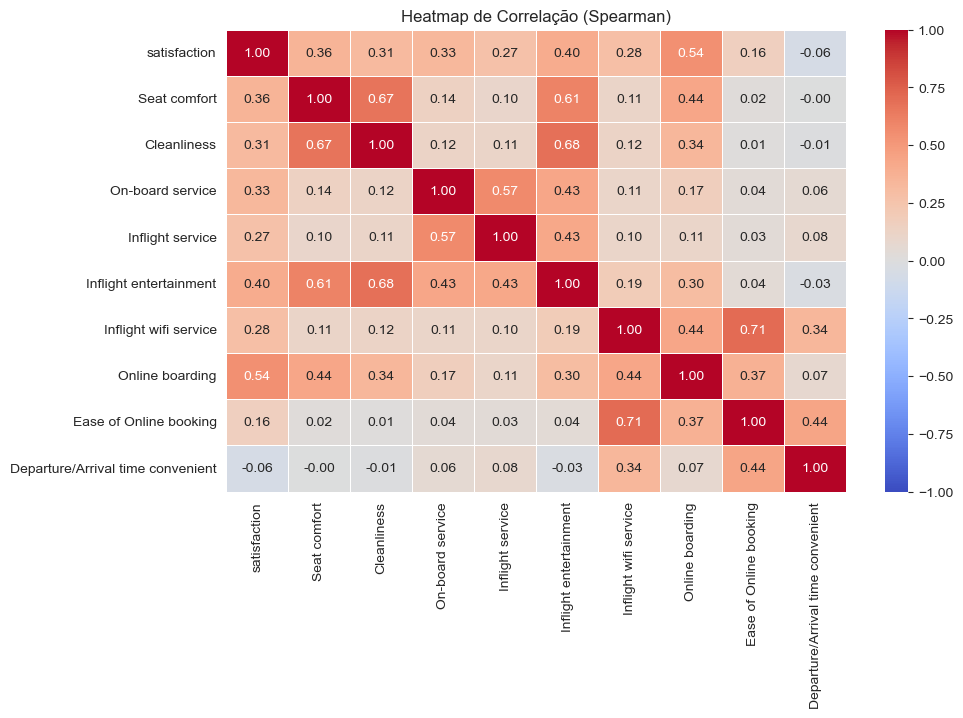

In [104]:
#Correlação de variáveis numéricas
corr_matrix = df[['satisfaction', 'Seat comfort', 'Cleanliness', 'On-board service', 'Inflight service', 'Inflight entertainment',
                  'Inflight wifi service', 'Online boarding', 'Ease of Online booking', 'Departure/Arrival time convenient']].corr(method='spearman')

#Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Heatmap de Correlação (Spearman)')
plt.show()

In [106]:
#Predição usando RandomForest

#Separação de colunas relevantes
X = df.drop(columns=['satisfaction', 'Inflight service', 'Inflight wifi service', 'Ease of Online booking',
                    'Gender', 'Customer Type', 'Age Range', 'Age', 'Departure Delay Category',
                    'Arrival Delay Category', 'id', 'Departure/Arrival time convenient', 'Flight Distance'])
y = df['satisfaction']

#Converter categóricas em numéricas
categorical_cols = X.select_dtypes(include=['object']).columns

le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

In [108]:
#Treino do modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)

rf_model = RandomForestClassifier(n_estimators=100, random_state=40)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=40)

In [109]:
#Avaliação do modelo
y_pred = rf_model.predict(X_test)

print(f'Matriz de Confusão: \n{confusion_matrix(y_test, y_pred)}\n')

print(f'Relatório de Classificação: \n{classification_report(y_test, y_pred)}')

Matriz de Confusão: 
[[2749  166]
 [ 283 1998]]

Relatório de Classificação: 
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2915
           1       0.92      0.88      0.90      2281

    accuracy                           0.91      5196
   macro avg       0.91      0.91      0.91      5196
weighted avg       0.91      0.91      0.91      5196



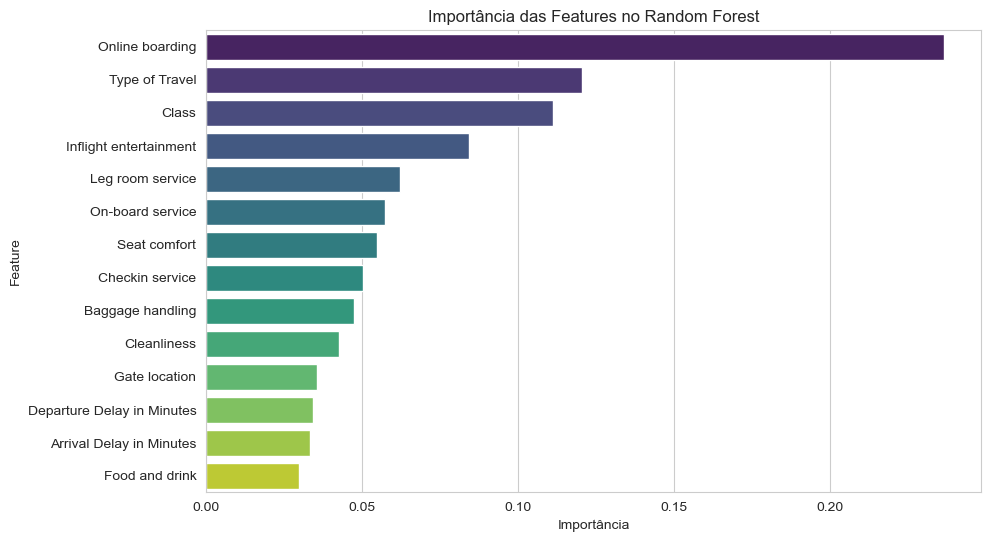

In [112]:
#Importancia das features
feature_importances = rf_model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], 
            hue=importance_df['Feature'], legend=False, palette="viridis")
plt.title('Importância das Features no Random Forest')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()

In [89]:
df.to_csv('airline_satisfaction.csv', index=False)

In [114]:
importance_df.to_csv('important_features.csv', index=False)